# WQD7005 Data Mining

# Milestone 4

In [110]:
#importing libraries
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

import pyodbc

# 1.Access data from Hive database

In [111]:
conn = pyodbc.connect(DSN = "hive_connection", autocommit = True, ansi = True)

print(conn)

In [112]:
df = pd.read_sql("SELECT * FROM bitcoin", conn, parse_dates=['date'])
df.head()

,bitcoin.marketdate,bitcoin.open,bitcoin.high,bitcoin.low,bitcoin.close,bitcoin.volume,bitcoin.marketcapacity
0,2020-05-25,8786.11,8951.01,8719.67,8906.93,3.128816e+10,1.637605e+11
1,2020-05-24,9212.28,9288.40,8787.25,8790.37,3.251880e+10,1.616104e+11
2,2020-05-23,9185.06,9302.50,9118.11,9209.29,2.772787e+10,1.693055e+11
3,2020-05-22,9080.33,9232.94,9008.64,9182.58,2.981077e+10,1.688076e+11
4,2020-05-21,9522.74,9555.24,8869.93,9081.76,3.932616e+10,1.669480e+11


In [113]:
df = df[::-1].reset_index(drop=True) # sort date and reindex
btc = df.set_index('bitcoin.marketdate')
btc.index = pd.to_datetime(btc.index)
target_col = 'close'
btc.head(5)

,bitcoin.open,bitcoin.high,bitcoin.low,bitcoin.close,bitcoin.volume,bitcoin.marketcapacity
bitcoin.marketdate,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,0.0,1.488567e+09
2013-04-29,134.44,147.49,134.00,144.54,0.0,1.603769e+09
2013-04-30,144.00,146.93,134.05,139.00,0.0,1.542813e+09
2013-05-01,139.00,139.89,107.72,116.99,0.0,1.298955e+09
2013-05-02,116.38,125.60,92.28,105.21,0.0,1.168517e+09


# 2.Prepare data for training and testing.

In [114]:
def train_test_split(btc, test_size=0.2):
    split_row = len(btc) - int(test_size * len(btc))
    train_data = btc.iloc[:split_row]
    test_data = btc.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(btc, test_size=0.2)

In [115]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Closing price ', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)  

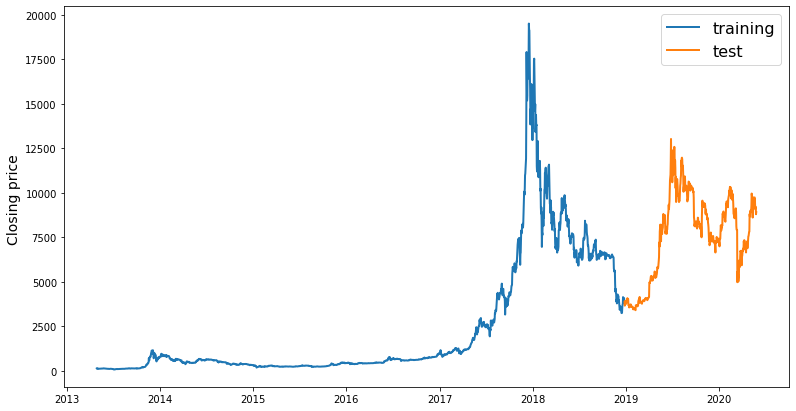

In [116]:
line_plot(train['bitcoin.close'], test['bitcoin.close'], 'training', 'test', title='')

# 3.Predict the price of crptocurrency using LSTM neural network.

In [181]:
data = btc.iloc[:, 0]
history = []
target = []
length = 90

for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    history.append(x)
    target.append(y)

In [183]:
history = np.array(history)  # convert data to numpy array and reshape the target

target = np.array(target)
target = target.reshape(-1,1)

print(history.shape, target.shape)

In [185]:

scaler = MinMaxScaler()
history_scaled = scaler.fit_transform(history)
target_scaled = scaler.fit_transform(target)

In [186]:

history_scaled = history_scaled.reshape((len(history_scaled), length, 1))

print(history_scaled.shape) # reshape the input array to be compatible with LSTM model

(2495, 90, 1)


In [187]:
X_train = history_scaled[:2400,:,:] # 2400 days used for training whereas 95 days used for testing
X_test = history_scaled[2400:,:,:]

y_train = target_scaled[:2400,:]
y_test = target_scaled[2400:,:]

# Build a LSTM Model

In [176]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss=loss, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]), dropout=0.2))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [209]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 30
batch_size = 32
loss = 'mean_squared_error'
dropout = 0.2
optimizer = 'adam'
hist= btc
target_col = ['bitcoin.close']

In [188]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_9 (Activation)    (None, 1)                 0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [189]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/30
2400/2400 [==============================] - 82s 34ms/step - loss: 0.0145
Epoch 2/30
2400/2400 [==============================] - 81s 34ms/step - loss: 0.0136
Epoch 3/30
2400/2400 [==============================] - 54s 23ms/step - loss: 0.0129
Epoch 4/30
2400/2400 [==============================] - 84s 35ms/step - loss: 0.0118
Epoch 5/30
2400/2400 [==============================] - 73s 30ms/step - loss: 0.0054
Epoch 6/30
2400/2400 [==============================] - 108s 45ms/step - loss: 0.0040
Epoch 7/30
2400/2400 [==============================] - 90s 37ms/step - loss: 0.0028
Epoch 8/30
2400/2400 [==============================] - 38s 16ms/step - loss: 0.0030
Epoch 9/30
2400/2400 [==============================] - 90s 38ms/step - loss: 0.0021
Epoch 10/30
2400/2400 [==============================] - 51s 21ms/step - loss: 0.0027
Epoch 11/30
2400/2400 [==============================] - 55s 23ms/step - loss: 0.0021
Epoch 12/30
2400/2400 [==============================] - 79s 3

In [205]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.08480695038905559

# 4.Visualize the prediction results

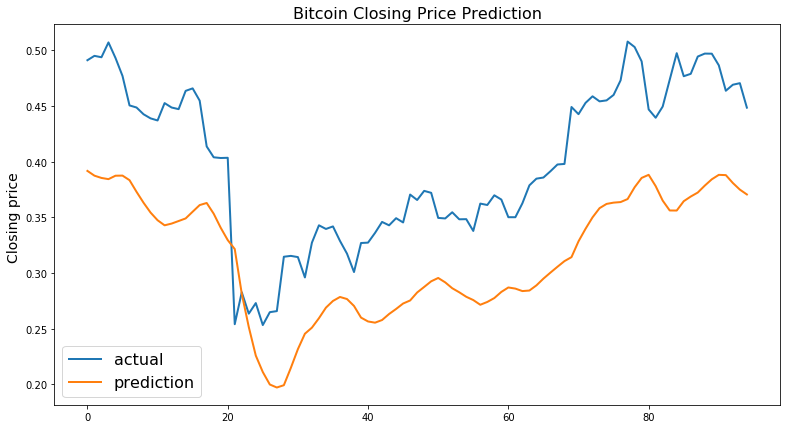

In [210]:
line_plot(y_test, preds, 'actual', 'prediction', title='Bitcoin Closing Price Prediction')